In [1]:
# !pip install kaggle
# !pip install kagglehub

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install Pillow
# !pip install scikit-learn

# !pip install seaborn

# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install torchsummary

# Setup

In [2]:
# Copy from kaggle
import kagglehub

# Download latest version
org_path = kagglehub.dataset_download("lantian773030/pokemonclassification")

print("Path to dataset files:", org_path)


Path to dataset files: C:\Users\CindyHong\.cache\kagglehub\datasets\lantian773030\pokemonclassification\versions\1


In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import ImageOps,ImageEnhance
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split
import scipy

from torchvision import models
from sklearn.utils.class_weight import compute_class_weight



In [4]:
np.random.seed(2024)

In [5]:
# Setting dataset path
path = os.path.join(org_path,'PokemonData')
path

'C:\\Users\\CindyHong\\.cache\\kagglehub\\datasets\\lantian773030\\pokemonclassification\\versions\\1\\PokemonData'

In [6]:
class_list = pd.read_csv('class_sheet.csv')

In [7]:
bad_class_list = class_list[class_list['Bad_Data'] == 1]['Pokemon']
bad_image_paths = []
valid_extensions = ['.jpg', '.jpeg', '.png']

In [8]:
# Removing all classes with bad data
class_list = class_list[class_list['Bad_Data'] != 1]

In [9]:
# Getting Pokemons that are winged and not winged
winged = class_list[class_list['Winged'] == 1]
winged = winged['Pokemon']
not_winged = class_list[class_list['Not_Winged'] == 1]
not_winged = not_winged['Pokemon']

In [10]:
# Making a data frame that has the image arrays and their classifcation
images = []
wrong_extensions = []

for folder in winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        if not os.path.exists(image_path):
            print(image_path)
            continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Winged'})
            
for folder in not_winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        if not os.path.exists(image_path):
            print(image_path)
            continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Not Winged'})
            
df = pd.DataFrame(images)
set(wrong_extensions)

{'.asp',
 ".jpg')",
 '.jpg~c200',
 '.sb-334870d9-FK2TVI',
 '.sb-334870d9-nlD60H',
 '.svg'}

In [11]:
# Sanity check to make sure there are only 2 classes
for index, row in df.iterrows():
    if row['Source'] not in ['Winged', 'Not Winged']:
        print(row)

# Data Preprocessing

In [12]:
# Normalizing function
def zscore(img,default = False):
    img = img.astype(np.float32)
    for c in range(img.shape[2]):
        if not default:
            mean = img[:,:,c].mean()
            std = img[:,:,c].std()
        else:
            mean=[0.485, 0.456, 0.406][c]
            std=[0.229, 0.224, 0.225][c]
        if std > 0:
            img[:,:,c] = (img[:,:,c] - mean) / std
        else:
            img[:,:,c] = (img[:,:,c] - mean)
    return img

def minmax(img):
    img = img.astype(np.float32)
    for c in range(img.shape[2]):
        max = img[:,:,c].max()
        min = img[:,:,c].min()
        img[:,:,c] = (img[:,:,c] - min) / (max - min)
    return img

In [13]:
# Going through all images and resizing them, converting them to grayscale or RGB and normalizing pixel values
def preprocess(df, pattern, default=False, batch_size=100):
    X = []
    y = []
    new_size = (224, 224)
    for start in range(0, len(df), batch_size):
        batch_df = df.iloc[start:start + batch_size]
        X_batch = []
        y_batch = []
        for _, row in batch_df.iterrows():
            # Resize images to 224 x 224
            img = Image.fromarray(row['Image']).resize(new_size)
            if pattern == 'Grayscale':
                # Convert images to grayscale
                img = img.convert('L')
                img = np.array(img) / 255.0
            else:
                img = img.convert('RGB')
                img = np.array(img)
                # Zscore normalization
                if pattern == 'Zscore':
                    img = zscore(img, default=default)
                # Minmax normalization
                elif pattern == 'Minmax':
                    img = minmax(img)

            X_batch.append(img)
            y_batch.append(1 if row['Source'] == 'Winged' else 0)
        
        X.append(np.array(X_batch))
        y.append(np.array(y_batch))
    
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y
# (n,224,224,3) or (n,224,224)

In [17]:
pattern = 'Zscore'
X,y = preprocess(df,pattern)
X.shape

(6017, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

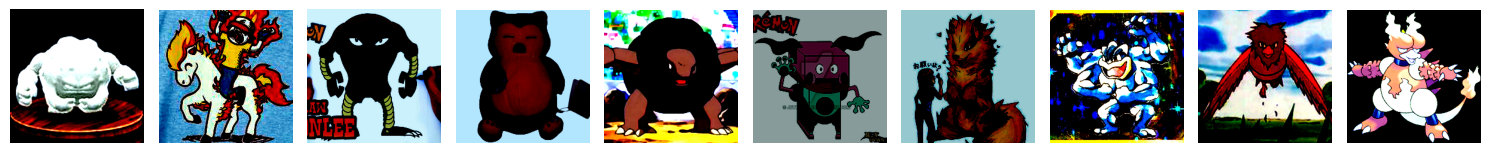

In [18]:
# Plotting 10 images after Zscore
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [19]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X.shape

(6017, 224, 224, 3)

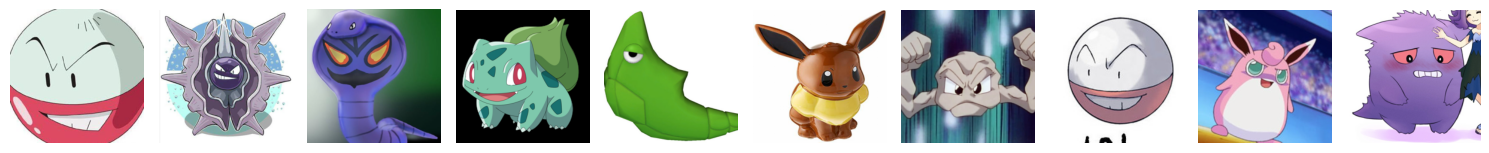

In [20]:
# Plotting 10 images after Minmax
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [21]:
pattern = 'Grayscale'
X,y = preprocess(df,pattern)
X.shape

(6017, 224, 224)

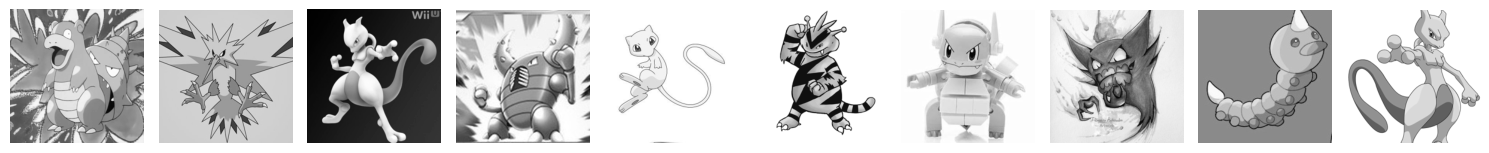

In [22]:
# Plotting 10 images after Grayscale
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img,cmap="gray") 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [14]:
######## We can also use some optimization methods to train on imbalanced dataset ########
# Balancing the data set by random sampling
def random_sample(X,y):
    id_not_winged = np.where(y == 0)[0]
    id_winged = np.where(y == 1)[0]
    sample_not_winged = np.random.choice(id_not_winged, size=600, replace=False)
    sample_winged = np.random.choice(id_winged, size=600, replace=False)
    sample = np.concatenate((sample_not_winged, sample_winged), axis=0)
    X = X[sample]
    y = y[sample]
    return X,y
######## We can also use some optimization methods to train on imbalanced dataset ########

# Creating Train/Validate/Test splits (80/10/10)
def random_split(X,y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=2024, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2024, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val,y_test

# X , y = random_sample(X,y)
# X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)

In [15]:
# Augmentation function
# Our resized image doesn't have enough space for shearing or zooming
def augmentation(img,pattern,img_size=(224,224),horizontal_flip=True,vertical_flip=False,rotation_range=20, horizontal_shift=0.2, vertical_shift=0.2):
    if img.dtype == np.float32:
        img = (img * 255).astype(np.uint8)
    if pattern != 'Grayscale':
        mean = tuple(np.mean(img,axis=(0,1)).astype(int))
    else:
        mean = 0
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    # Flipping
    if horizontal_flip and np.random.random() < 0.5:
        img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    if vertical_flip and np.random.random() < 0.5:
        img = img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
    # Rotating
    if rotation_range > 0:
        rotation_range = np.random.randint(-rotation_range, rotation_range)
        img = img.rotate(rotation_range, resample=Image.BICUBIC,fillcolor=mean)
    # Shifting
    if horizontal_shift > 0 or vertical_shift > 0:
        w , h = img_size
        dw = np.random.randint(-horizontal_shift * w, horizontal_shift * w)
        dh = np.random.randint(-vertical_shift * h, vertical_shift * h)
        img = ImageOps.expand(img, border=(abs(dw),abs(dh),abs(dw),abs(dh)),fill=mean)
        img = img.crop((dw+abs(dw),dh+abs(dh),dw+abs(dw)+w,dh+abs(dh)+h))
    # Ensure the sizes
    img = img.resize(img_size)
    img = np.array(img).astype(np.float32) / 255.0
    return img

In [16]:
# Going through all images and augment them
def augment_loop(X_train,y_train,pattern,img_size=(224,224),horizontal_flip=True,vertical_flip=False,rotation_range=20, horizontal_shift=0.2, vertical_shift=0.2):
    X_augmented = []
    y_augmented = []
    for img, label in zip(X_train,y_train):
        X_augmented.append(img)
        img = augmentation(img,pattern,img_size,horizontal_flip,vertical_flip,rotation_range, horizontal_shift, vertical_shift)
        X_augmented.append(img)
        y_augmented.append(label)
        y_augmented.append(label)
    X_train = np.array(X_augmented)
    y_train = np.array(y_augmented)
    return X_train, y_train

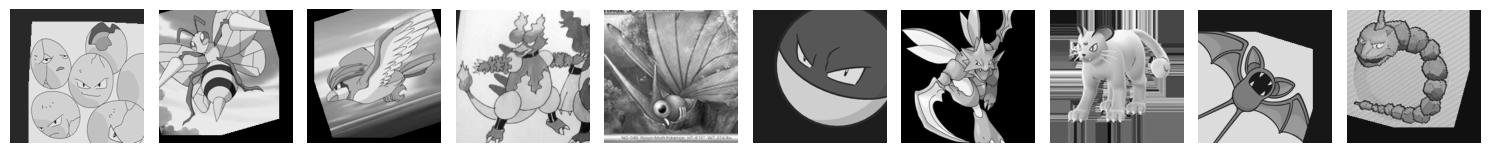

In [27]:
# Plotting 10 images after augmenting
pattern = 'Grayscale'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)
X_random_id = np.random.choice(X_train.shape[0], 10, replace=False)
X_random = X_train[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img,cmap="gray") 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [28]:
X_train.shape, X_val.shape, X_test.shape

((1920, 224, 224), (120, 224, 224), (120, 224, 224))

# Model Training

## data visualization

In [17]:
# Print classification report and Plot confusion matrix
def report_cm(model,X_train,y_train,X_val,y_val):
    y_train_pred = model.predict(X_train)
    print(classification_report(y_train,y_train_pred))
    cm_train = confusion_matrix(y_train,y_train_pred)
    
    y_val_pred = model.predict(X_val)
    print(classification_report(y_val,y_val_pred))
    cm_val = confusion_matrix(y_val,y_val_pred)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Train')
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Val')
    plt.show()


## ML

### Logistic Regression

In [18]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [19]:
X_train.shape

(1920, 224, 224, 3)

In [20]:
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       960

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920

              precision    recall  f1-score   support

           0       0.61      0.63      0.62        60
           1       0.62      0.60      0.61        60

    accuracy                           0.62       120
   macro avg       0.62      0.62      0.62       120
weighted avg       0.62      0.62      0.62       120



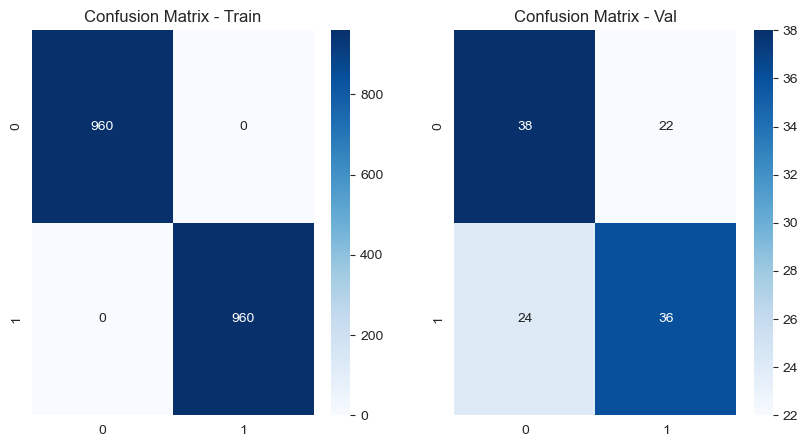

In [21]:
LR = LogisticRegression(max_iter=1000)
LR.fit(X_flattened_train, y_train)

report_cm(LR,X_flattened_train,y_train,X_flattened_val,y_val)

### SVM

In [17]:
# pattern = 'Minmax'
# X,y = preprocess(df,pattern)
# X , y = random_sample(X,y)
# X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
# X_train, y_train = augment_loop(X_train,y_train,pattern)

In [19]:
# X_flattened_train = X_train.reshape(X_train.shape[0], -1)
# X_flattened_val = X_val.reshape(X_val.shape[0], -1)
# X_flattened_test = X_test.reshape(X_test.shape[0], -1)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       960
           1       0.90      0.93      0.91       960

    accuracy                           0.91      1920
   macro avg       0.91      0.91      0.91      1920
weighted avg       0.91      0.91      0.91      1920

              precision    recall  f1-score   support

           0       0.66      0.63      0.64        60
           1       0.65      0.67      0.66        60

    accuracy                           0.65       120
   macro avg       0.65      0.65      0.65       120
weighted avg       0.65      0.65      0.65       120



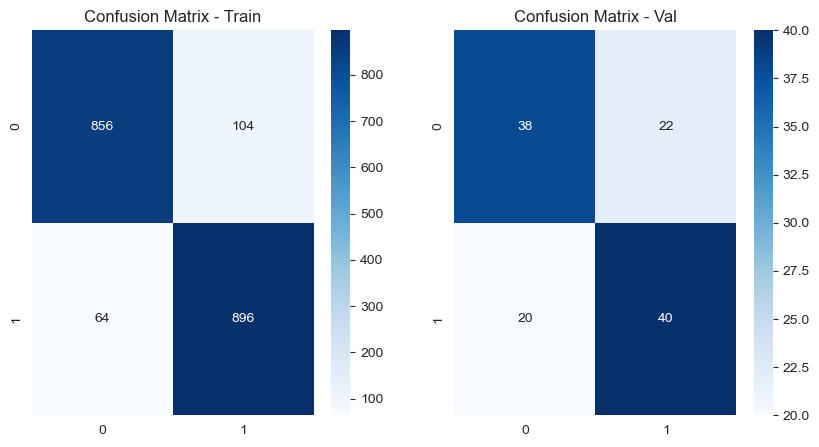

In [22]:
svm_rbf = SVC(kernel = 'rbf')
svm_rbf.fit(X_flattened_train, y_train)

report_cm(svm_rbf,X_flattened_train,y_train,X_flattened_val,y_val)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       960

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920

              precision    recall  f1-score   support

           0       0.69      0.58      0.63        60
           1       0.64      0.73      0.68        60

    accuracy                           0.66       120
   macro avg       0.66      0.66      0.66       120
weighted avg       0.66      0.66      0.66       120



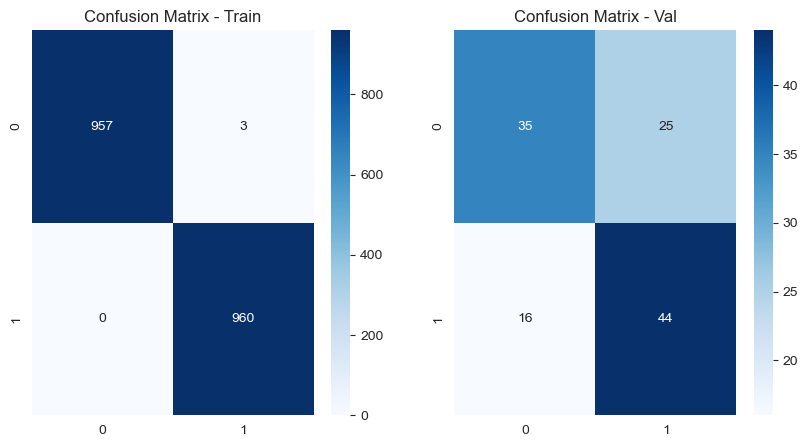

In [23]:
svm_poly = SVC(kernel = 'poly')
svm_poly.fit(X_flattened_train, y_train)

report_cm(svm_poly,X_flattened_train,y_train,X_flattened_val,y_val)

### KNN

In [21]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [22]:
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

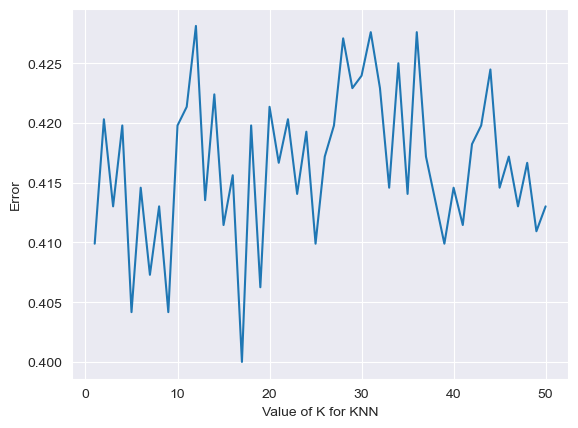

In [23]:
# Picking suitable value of k
from sklearn.model_selection import cross_val_score
k_range = range(1, 51)
k_error = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_flattened_train, y_train, cv=6, scoring='accuracy', verbose=1)
    k_error.append(1 - scores.mean())
plt.plot(k_range, k_error)
plt.xlabel('Value of K for KNN')
plt.ylabel('Error')
plt.show()


              precision    recall  f1-score   support

           0       0.65      0.85      0.74       960
           1       0.79      0.53      0.64       960

    accuracy                           0.69      1920
   macro avg       0.72      0.69      0.69      1920
weighted avg       0.72      0.69      0.69      1920

              precision    recall  f1-score   support

           0       0.57      0.80      0.67        60
           1       0.67      0.40      0.50        60

    accuracy                           0.60       120
   macro avg       0.62      0.60      0.58       120
weighted avg       0.62      0.60      0.58       120



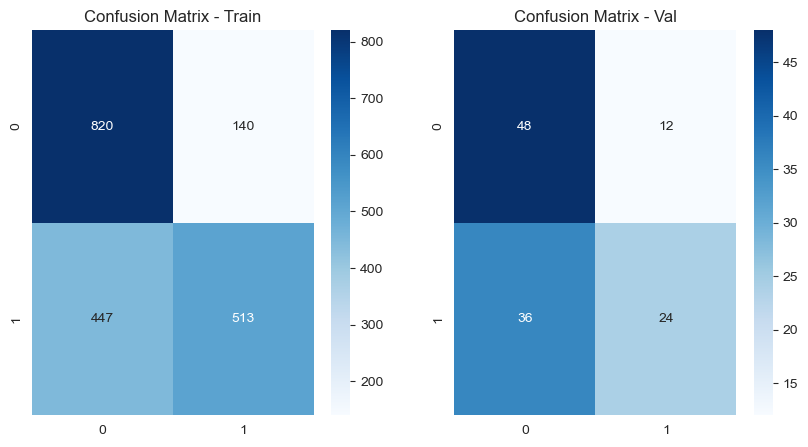

In [24]:
k=10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_flattened_train, y_train)

report_cm(knn,X_flattened_train,y_train,X_flattened_val,y_val)


### Naive Bayes

In [25]:
pattern = 'Zscore'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
# X_train, y_train = augment_loop(X_train,y_train,pattern)

In [26]:
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

              precision    recall  f1-score   support

           0       0.65      0.72      0.69       480
           1       0.69      0.61      0.65       480

    accuracy                           0.67       960
   macro avg       0.67      0.67      0.67       960
weighted avg       0.67      0.67      0.67       960

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        60
           1       0.60      0.60      0.60        60

    accuracy                           0.60       120
   macro avg       0.60      0.60      0.60       120
weighted avg       0.60      0.60      0.60       120



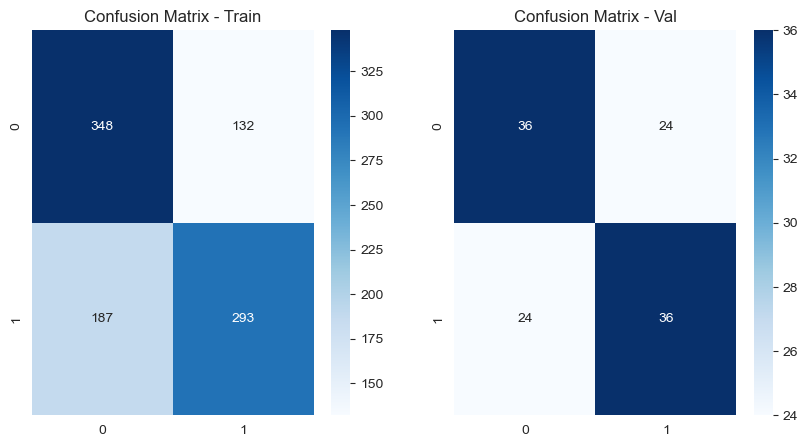

In [27]:
NB = GaussianNB()
NB.fit(X_flattened_train, y_train)

report_cm(NB,X_flattened_train,y_train,X_flattened_val,y_val)

## DL

In [32]:

def get_losses(losses,loader, model, device):
    loss = 0.0
    model.eval() 
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            l = criterion(outputs, targets)
            loss += l.item()
    loss /= len(loader)
    losses.append(loss)
    return losses

def get_predictions(loader, model, device):
    all_targets = []
    all_predictions = []
    model.eval() 
    # for epoch in range(epoches):
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    return all_targets,all_predictions

# Plot loss curve and confusion matrix for NNs
def loss_curve(epoches,train_losses,val_losses):
    # loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoches + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epoches + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Curve')
    plt.legend()
    plt.show()

def plot_confusion_matrix_train_val(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions):

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # calculate confusion matrix
    cm = confusion_matrix(all_train_targets, all_train_predictions)
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Train')
    
    plt.subplot(1, 2, 2)
    # calculate confusion matrix
    cm = confusion_matrix(all_val_targets, all_val_predictions)
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Val')
    plt.show()
    
def print_confusion_matrix_train_val(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions):   
    print(classification_report(all_train_targets,all_train_predictions))
    print(classification_report(all_val_targets,all_val_predictions))

### Dataloader

In [28]:
class ImageDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx],dtype=torch.float32)
        label = torch.tensor(self.labels[idx],dtype=torch.long)
        
        return image, label

### CNN

In [33]:
class CNN(nn.Module):
    def __init__(self,image_size=(3,224,224), num_classes=2,dropout = 0.25):
        super(CNN, self).__init__()
        c,h,w = image_size
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        # self.bn3 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.flattened_size = 128 * (h // 4) * (w // 4) 
        self.fc = nn.Linear(self.flattened_size, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        # x = self.bn3(self.conv3(x))
        # x = self.pool(x)
        
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [24]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [25]:
X_train = X_train.transpose(0,3,1,2)
X_val = X_val.transpose(0,3,1,2)
X_test = X_test.transpose(0,3,1,2)
X_train.shape

(1920, 3, 224, 224)

In [34]:
torch.manual_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CNN = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(CNN.parameters(),lr=0.01,weight_decay=1e-4)

epoches = 10
datas = []
val_datas = []

# Create DataLoaders for training and testing
dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val,y_val)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_losses = []
val_losses = []

for epoch in range(epoches):
    CNN.train()
       
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if i%15==0:
                print(f'Epoch [{epoch+1}/{epoches}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    train_losses = get_losses(train_losses,train_loader, CNN, device)
    val_losses = get_losses(val_losses,val_loader, CNN, device)



cuda
Epoch [1/10], Step [1/30], Loss: 0.6775
Epoch [1/10], Step [16/30], Loss: 55.6147
Epoch [2/10], Step [1/30], Loss: 33.8827
Epoch [2/10], Step [16/30], Loss: 47.1745
Epoch [3/10], Step [1/30], Loss: 22.7777
Epoch [3/10], Step [16/30], Loss: 19.5609
Epoch [4/10], Step [1/30], Loss: 40.3765
Epoch [4/10], Step [16/30], Loss: 10.3738
Epoch [5/10], Step [1/30], Loss: 6.2517
Epoch [5/10], Step [16/30], Loss: 4.2349
Epoch [6/10], Step [1/30], Loss: 3.3969
Epoch [6/10], Step [16/30], Loss: 1.4975
Epoch [7/10], Step [1/30], Loss: 1.6305
Epoch [7/10], Step [16/30], Loss: 1.9003
Epoch [8/10], Step [1/30], Loss: 0.3401
Epoch [8/10], Step [16/30], Loss: 1.0153
Epoch [9/10], Step [1/30], Loss: 0.6602
Epoch [9/10], Step [16/30], Loss: 1.6674
Epoch [10/10], Step [1/30], Loss: 0.6530
Epoch [10/10], Step [16/30], Loss: 0.9502


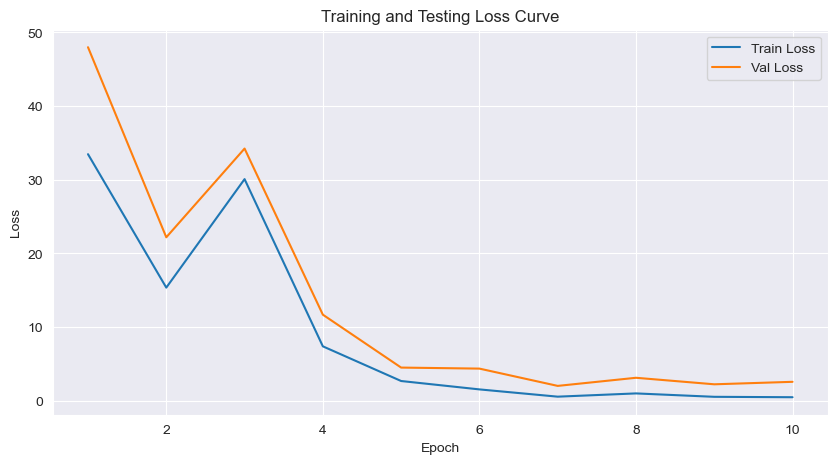

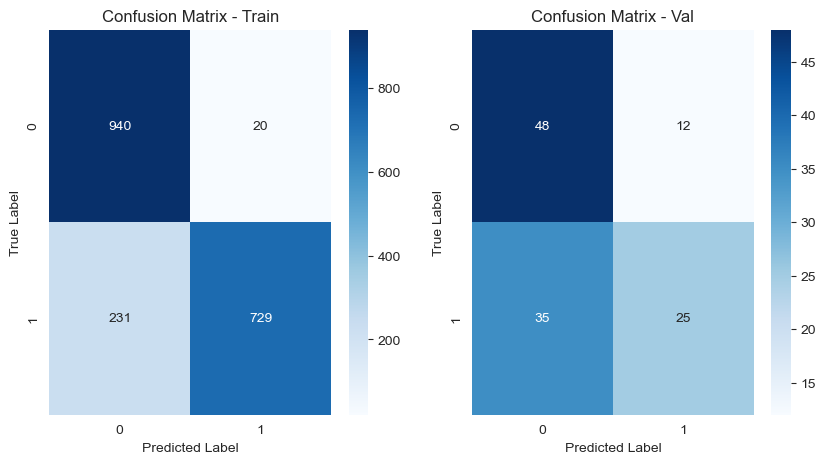

In [35]:
# evaluate model

all_train_targets = []
all_train_predictions = []

all_train_targets,all_train_predictions = get_predictions(train_loader, CNN, device)

all_val_targets = []
all_val_predictions = []

all_val_targets,all_val_predictions = get_predictions(val_loader, CNN, device)

# loss curve
loss_curve(epoches, train_losses, val_losses)

plot_confusion_matrix_train_val(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions)



In [36]:
print_confusion_matrix_train_val(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions)

torch.cuda.empty_cache()

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       960
           1       0.97      0.76      0.85       960

    accuracy                           0.87      1920
   macro avg       0.89      0.87      0.87      1920
weighted avg       0.89      0.87      0.87      1920

              precision    recall  f1-score   support

           0       0.58      0.80      0.67        60
           1       0.68      0.42      0.52        60

    accuracy                           0.61       120
   macro avg       0.63      0.61      0.59       120
weighted avg       0.63      0.61      0.59       120



### Resnet18

In [37]:
pattern = 'Zscore'
X,y = preprocess(df,pattern,default=True)
# X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
# X_train, y_train = augment_loop(X_train,y_train,pattern)

In [38]:
X_train = X_train.transpose(0,3,1,2)
X_val = X_val.transpose(0,3,1,2)
X_test = X_test.transpose(0,3,1,2)
X_train.shape

(4813, 3, 224, 224)

In [39]:
torch.manual_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Resnet18 = models.resnet18(pretrained=True)
Resnet18.fc = nn.Linear(Resnet18.fc.in_features, 2)  # Binary classification (0 and 1)
Resnet18 = Resnet18.to(device)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(Resnet18.parameters(), lr=0.001, weight_decay=1e-4)

epoches = 10
datas = []
val_datas = []

# Create DataLoaders for training and testing
dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val,y_val)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
   
train_losses = []
val_losses = []

for epoch in range(epoches):
    Resnet18.train()   
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device).long()
        optimizer.zero_grad()
        outputs = Resnet18(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if i%15==0:
                print(f'Epoch [{epoch+1}/{epoches}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')        
    
    train_losses = get_losses(train_losses,train_loader, Resnet18, device)
    val_losses = get_losses(val_losses,val_loader, Resnet18, device)


cuda


C:\Users\CindyHong\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CindyHong\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Step [1/151], Loss: 0.6385
Epoch [1/10], Step [16/151], Loss: 2.4163
Epoch [1/10], Step [31/151], Loss: 0.3562
Epoch [1/10], Step [46/151], Loss: 0.4562
Epoch [1/10], Step [61/151], Loss: 0.6168
Epoch [1/10], Step [76/151], Loss: 0.3199
Epoch [1/10], Step [91/151], Loss: 0.2094
Epoch [1/10], Step [106/151], Loss: 0.2313
Epoch [1/10], Step [121/151], Loss: 0.3633
Epoch [1/10], Step [136/151], Loss: 0.3775
Epoch [1/10], Step [151/151], Loss: 0.1243
Epoch [2/10], Step [1/151], Loss: 0.1613
Epoch [2/10], Step [16/151], Loss: 0.4812
Epoch [2/10], Step [31/151], Loss: 0.2341
Epoch [2/10], Step [46/151], Loss: 0.1764
Epoch [2/10], Step [61/151], Loss: 0.1798
Epoch [2/10], Step [76/151], Loss: 0.1796
Epoch [2/10], Step [91/151], Loss: 0.6765
Epoch [2/10], Step [106/151], Loss: 0.2701
Epoch [2/10], Step [121/151], Loss: 0.2887
Epoch [2/10], Step [136/151], Loss: 0.1153
Epoch [2/10], Step [151/151], Loss: 0.5628
Epoch [3/10], Step [1/151], Loss: 0.3583
Epoch [3/10], Step [16/151], 

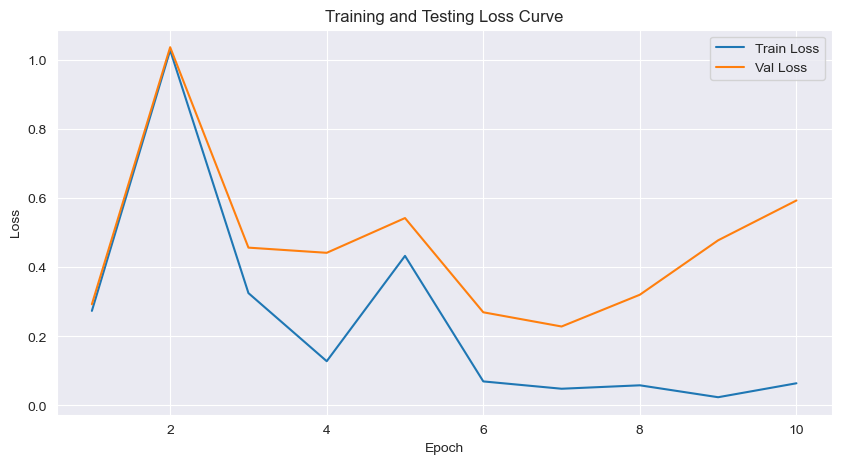

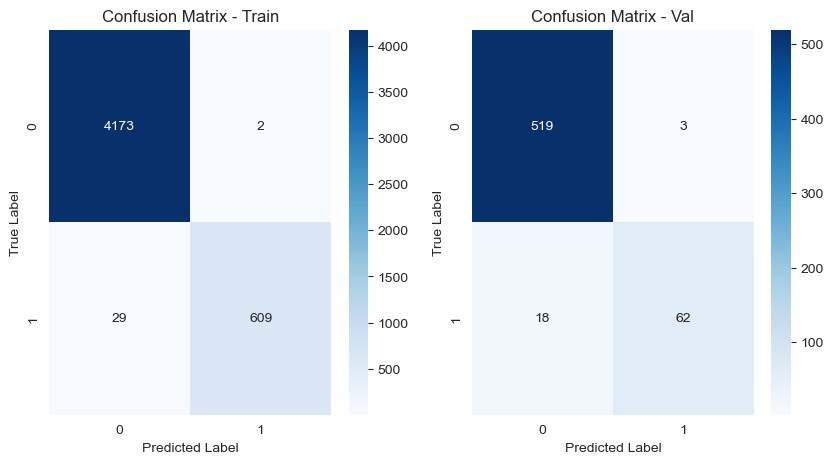

In [40]:
# evaluate model
# Resnet18.eval()
all_val_targets = []
all_val_predictions = []

# for epoch in range(epoches)
all_val_targets,all_val_predictions = get_predictions(val_loader, Resnet18, device)

all_train_targets = []
all_train_predictions = []

# for epoch in range(epoches):
all_train_targets,all_train_predictions= get_predictions(train_loader, Resnet18, device)

# loss curve
loss_curve(epoches, train_losses, val_losses)

plot_confusion_matrix_train_val(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions)

torch.cuda.empty_cache()

In [41]:
print_confusion_matrix_train_val(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4175
           1       1.00      0.95      0.98       638

    accuracy                           0.99      4813
   macro avg       0.99      0.98      0.99      4813
weighted avg       0.99      0.99      0.99      4813

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       522
           1       0.95      0.78      0.86        80

    accuracy                           0.97       602
   macro avg       0.96      0.88      0.92       602
weighted avg       0.96      0.97      0.96       602

